In [2]:
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
'''
Taken from Pytorch tutorail, modified for mnist
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='~/data/mnist_root', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='~/data/mnist_root', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

tensor(4) tensor(9) tensor(1) tensor(4)


Process Process-2:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = sel

In [32]:
# conv net
class Net (nn.Module):
    conv_layers = [64, 64, 'pool', 128, 128, 'pool', 128, 128, 'pool']

    def __init__(self):
        super(Net, self).__init__()
        
        layers = []
        self.in_channel = 1
        
        for layer in self.conv_layers:
            if layer is 'pool':
                layers += [nn.MaxPool2d(2, 2)]
            else:
                layers += [nn.Conv2d(self.in_channel, layer, 1, padding=1),
                           nn.ReLU(inplace=True)]
                self.in_channel = layer
                
        self.conv = nn.Sequential(*layers)
        self.fc = nn.Sequential(nn.Linear(6272, 256),
                               nn.ReLU(inplace=True),
                               nn.Linear(256, 10))
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [38]:
net = Net().cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [80]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(Variable(inputs).cuda())
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5000 == 4999:    # print every 5000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5000))
            running_loss = 0.0

print('Finished Training')

[1,  5000] loss: 0.148
[1, 10000] loss: 0.159
[1, 15000] loss: 0.164
[2,  5000] loss: 0.138
[2, 10000] loss: 0.149
[2, 15000] loss: 0.154
[3,  5000] loss: 0.123
[3, 10000] loss: 0.135
[3, 15000] loss: 0.152
[4,  5000] loss: 0.119
[4, 10000] loss: 0.130
[4, 15000] loss: 0.137
[5,  5000] loss: 0.108
[5, 10000] loss: 0.119
[5, 15000] loss: 0.129
Finished Training


GroundTruth:  tensor(7) tensor(2) tensor(1) tensor(0)
Predicted:  tensor(7, device='cuda:0') tensor(2, device='cuda:0') tensor(1, device='cuda:0') tensor(0, device='cuda:0')


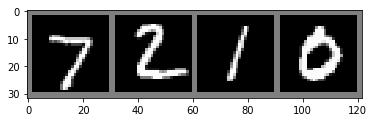

In [63]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

outputs = net(images.cuda())
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(4)))

In [81]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        labels = labels.cuda()
        outputs = net(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 89 %


In [82]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 93 %
Accuracy of     1 : 98 %
Accuracy of     2 : 89 %
Accuracy of     3 : 87 %
Accuracy of     4 : 87 %
Accuracy of     5 : 81 %
Accuracy of     6 : 92 %
Accuracy of     7 : 89 %
Accuracy of     8 : 87 %
Accuracy of     9 : 88 %


In [83]:
# saves the model
torch.save(net.state_dict(), 'best-20epochs.pt')